# Pixel splitting

This notebook demonstrates the layout of pixel in polar coordinates on a small detector (5x5 pixels) to demonstrate pixel splitting and pixel reorganisation.

In a second part, it displays the effect of the splitting scheme on 2D integration.

In [1]:
# %matplotlib widget
#For documentation purpose, `inline` is used to enforce the storage of the image in the notebook
%matplotlib inline
import time
import numpy
from matplotlib.pyplot import subplots
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
start_time = time.perf_counter()

In [2]:
import fabio
import pyFAI.test.utilstest
from pyFAI.gui import jupyter
import pyFAI, pyFAI.units
from pyFAI.detectors import Detector
from pyFAI.integrator.azimuthal import AzimuthalIntegrator
from pyFAI.ext import splitPixel
print(f"Using pyFAI version {pyFAI.version}")

Using pyFAI version 2025.12.1-dev0


In [3]:
# Define a dummy 5x5 detector with 1mm pixel size
det = Detector(1e-3, 1e-3, max_shape=(5,5))
print(det)

Detector Detector	 PixelSize= 1mm, 1mm	 BottomRight (3)


In [4]:
def area4(a0, a1, b0, b1,c0,c1,d0,d1):
    """
    Calculate the area of the ABCD polygon with 4 with corners:
    
    A(a0,a1)
    B(b0,b1)
    C(c0,c1)
    D(d0,d1)
    :return: area, i.e. 1/2 * (AC ^ BD)
    """
    return 0.5 * (((c0 - a0) * (d1 - b1)) - ((c1 - a1) * (d0 - b0)))

In [5]:
# Example of code for spotting pixel on the azimuthal discontinuity: its area has not the same sign!

chiDiscAtPi = 1
pi = numpy.pi
two_pi = 2*numpy.pi

ai = AzimuthalIntegrator(1, 2.2e-3, 2.8e-3, rot3=-0.3, detector=det)
if chiDiscAtPi:
    ai.setChiDiscAtPi()
else:
    ai.setChiDiscAtZero()

pos = ai.array_from_unit(typ="corner", unit="r_mm", scale=True)

a = []
s = 0
ss = 0
disc = {}

for i0 in range(pos.shape[0]):
    for i1 in range(pos.shape[1]):
        p = pos[i0, i1].copy()
        area = area4(*p.ravel())
        area2 = None
        if area>=0:
            az = p[:, 1].copy()
            if chiDiscAtPi:
                m = numpy.where(az<0)
            else:
                m = numpy.where(az<pi)
            az[m] = two_pi + az[m]
            c1 = az.mean()
            if not chiDiscAtPi and c1>two_pi:
                az -= two_pi
            elif chiDiscAtPi and c1>pi:
                az -= two_pi
            
            disc[(i0, i1)] = list(zip(p.copy(),az))
            p[:, 1 ] = az
            area2 = area4(*p.ravel())
        print(f"({i0} {i1}) A = {area:.3f}" +(f" -> {area2:.3f}" if area2 else ""))
print("Discontinuities")
for k,v in disc.items():
    print(k)
    for l in v:
        print(f"    {l[0]} -> {l[1]:.7f}")

(0 0) A = -0.343
(0 1) A = -0.453
(0 2) A = -0.579
(0 3) A = -0.533
(0 4) A = -0.405
(1 0) A = -0.414
(1 1) A = -0.647
(1 2) A = -1.133
(1 3) A = -0.877
(1 4) A = -0.533
(2 0) A = 3.026 -> -0.432
(2 1) A = 4.995 -> -0.738
(2 2) A = 1.791 -> -0.874
(2 3) A = -1.133
(2 4) A = -0.579
(3 0) A = 3.896 -> -0.373
(3 1) A = -0.519
(3 2) A = -0.738
(3 3) A = -0.647
(3 4) A = -0.453
(4 0) A = -0.303
(4 1) A = -0.373
(4 2) A = -0.432
(4 3) A = -0.414
(4 4) A = -0.343
Discontinuities
(2, 0)
    [ 2.807134  -2.7702851] -> -2.7702851
    [ 2.912044  -3.1198924] -> -3.1198924
    [1.9697715 3.0233684] -> -3.2598171
    [ 1.811077  -2.7309353] -> -2.7309353
(2, 1)
    [ 1.811077  -2.7309353] -> -2.7309353
    [1.9697715 3.0233684] -> -3.2598171
    [1.1313709 2.6561944] -> -3.6269910
    [ 0.82462114 -2.596614  ] -> -2.5966139
(2, 2)
    [ 0.82462114 -2.596614  ] -> -2.5966139
    [1.1313709 2.6561944] -> -3.6269910
    [0.82462114 1.6258177 ] -> -4.6573677
    [ 0.28284273 -0.48539817] -> -0.4853983


The recenteriing of pixels is obtained from `pyFAI.ext.splitPixel.recenter` which is implemented in Cython to be more efficient.
Beware of the signature changed with pyFAI-2025.12

In [6]:
def display_geometry(pos):
    fig, ax = subplots()
    patches = []
    for i0 in range(pos.shape[0]):
        for i1 in range(pos.shape[1]):
            p = pos[i0, i1].astype("float64")
            splitPixel.recenter(p, chiDiscAtPi=chiDiscAtPi)
            p = numpy.concatenate((p, [p[0]]))
            ax.plot(p[:,0], p[:,1], "--")
            patches.append(Polygon(p))
            p = PatchCollection(patches, alpha=0.4)
    colors = numpy.linspace(0, 100, len(patches))
    p.set_array(colors)
    ax.add_collection(p)
    if chiDiscAtPi:
        ax.plot([0,4], [-pi, -pi])
    else:
        ax.plot([0,4], [two_pi, two_pi])
    ax.plot([0,4], [pi, pi])
    ax.plot([0,4], [0, 0])
    ax.set_xlabel(unit.label)
    ax.set_ylabel("Azimuthal angle (rad)")
    return ax

Card(χ<0π) = 1 	 Card(χ>2π) = 3


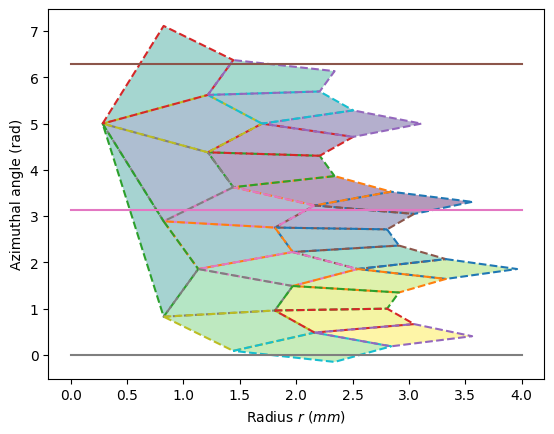

In [7]:
chiDiscAtPi = 0
unit = pyFAI.units.to_unit("r_mm")
ai = AzimuthalIntegrator(1, 2.2e-3, 2.8e-3, rot3=0.5, detector=det)
if chiDiscAtPi:
    ai.setChiDiscAtPi()
    low = -pi
    high = pi
else:
    ai.setChiDiscAtZero()
    low = 0
    high = two_pi
pos = ai.array_from_unit(typ="corner", unit=unit, scale=True)

ax = display_geometry(pos)

over = 0
under = 0
for i0 in range(pos.shape[0]):
    for i1 in range(pos.shape[1]):
        p = pos[i0, i1].copy()
        area = area4(*p.ravel())
        area2 = None
        if area>=0:
            az = p[:, 1]
            if chiDiscAtPi:
                m = numpy.where(az<0)
            else:
                m = numpy.where(az<pi)
            az[m] = two_pi + az[m]
            c1 = az.mean()
            if not chiDiscAtPi and c1>two_pi:
                az -= two_pi
            elif chiDiscAtPi and c1>pi:
                az -= two_pi
            over += (az>high).sum()
            under += (az<low).sum()
        
print(f"Card(χ<{low/pi:.0f}π) = {under} \t Card(χ>{high/pi:.0f}π) = {over}")

3.412953
3.329596
3.5415926
3.0282776
Card(χ<-1π) = 5 	 Card(χ>1π) = 1


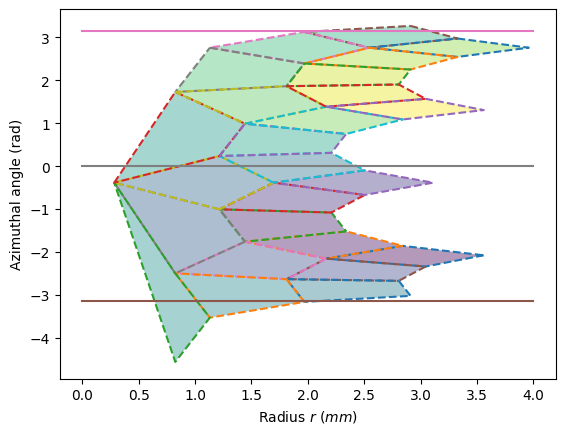

In [8]:
chiDiscAtPi = 1
pi = numpy.pi
two_pi = 2*numpy.pi

ai = AzimuthalIntegrator(1, 2.2e-3, 2.8e-3, rot3=-0.4, detector=det)
if chiDiscAtPi:
    ai.setChiDiscAtPi()
    low = -pi
    high = pi
else:
    ai.setChiDiscAtZero()
    low = 0
    high = two_pi

pos = ai.array_from_unit(typ="corner", unit="r_mm", scale=True)

_ = display_geometry(pos)
over = 0
under = 0
for i0 in range(pos.shape[0]):
    for i1 in range(pos.shape[1]):
        p = pos[i0, i1].copy()
        area = area4(*p.ravel())
        area2 = None
        if area>=0:
            az = p[:, 1]
            if chiDiscAtPi:
                m = numpy.where(az<0)
            else:
                m = numpy.where(az<pi)
            az[m] = two_pi + az[m]
            c1 = az.mean()
            print(c1)
            if c1>high:
                az -= two_pi
            over += (az>high).sum()
            under += (az<low).sum()
        
print(f"Card(χ<{low/pi:.0f}π) = {under} \t Card(χ>{high/pi:.0f}π) = {over}")

## Effect of pixel splitting on 2D integration

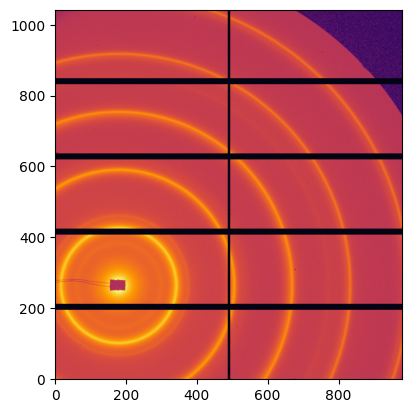

In [9]:
img = pyFAI.test.utilstest.UtilsTest.getimage("Pilatus1M.edf")
fimg = fabio.open(img)
_ = jupyter.display(fimg.data)

In [10]:
# Focus on the beam stop holder ...
poni = pyFAI.test.utilstest.UtilsTest.getimage("Pilatus1M.poni")
ai = pyFAI.load(poni)
print(ai)
ai.setChiDiscAtZero()

Detector Pilatus 1M	 PixelSize= 172µm, 172µm	 BottomRight (3)
Wavelength= 1.000000 Å
SampleDetDist= 1.583231e+00 m	PONI= 3.341702e-02, 4.122778e-02 m	rot1=0.006487  rot2=0.007558  rot3=0.000000 rad
DirectBeamDist= 1583.310 mm	Center: x=179.981, y=263.859 pix	Tilt= 0.571° tiltPlanRotation= 130.640° λ= 1.000Å


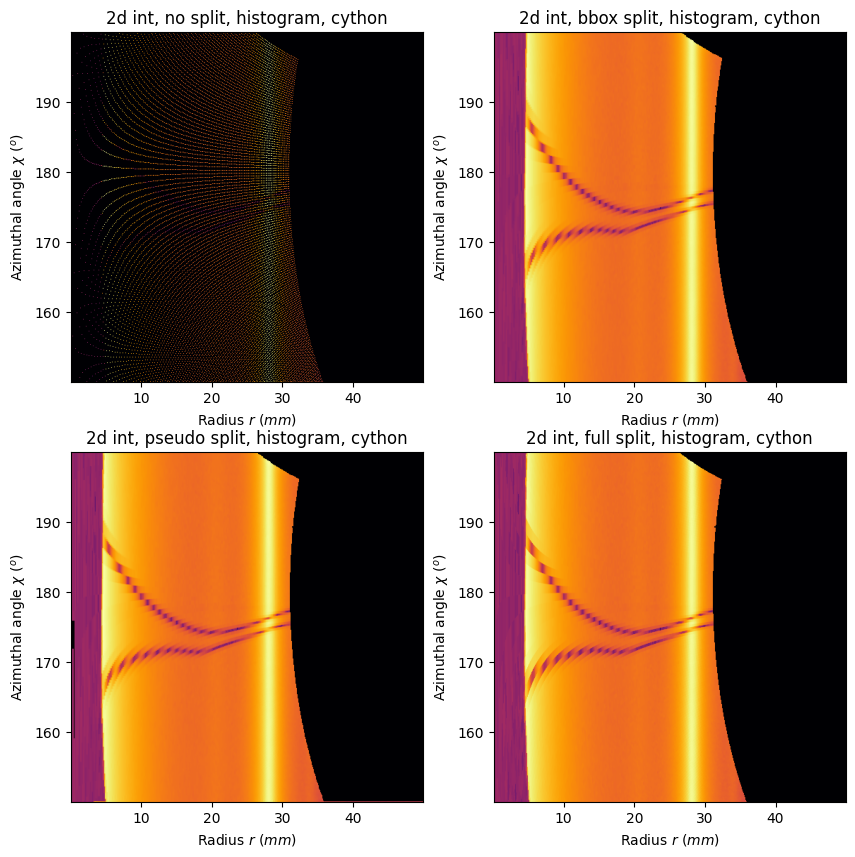

In [11]:
kwargs = {"data":fimg.data, 
          "npt_rad":500, 
          "npt_azim":500, 
          "unit":"r_mm",
          "dummy":-2, 
          "delta_dummy":2,
          "azimuth_range":(150,200),
          "radial_range":(0,50),
         }
resn = ai.integrate2d_ng(method=("no", "histogram", "cython"), **kwargs)
resb = ai.integrate2d_ng(method=("bbox", "histogram", "cython"), **kwargs)
resp = ai.integrate2d_ng(method=("pseudo", "histogram", "cython"), **kwargs)
resf = ai.integrate2d_ng(method=("full", "histogram", "cython"), **kwargs)
fig,ax = subplots(2,2, figsize=(10,10))

jupyter.plot2d(resn, ax=ax[0,0])
ax[0,0].set_title(resn.compute_engine.split("(")[1].strip(")"))
jupyter.plot2d(resb, ax=ax[0,1])
ax[0,1].set_title(resb.compute_engine.split("(")[1].strip(")"))
jupyter.plot2d(resp, ax=ax[1,0])
ax[1,0].set_title(resp.compute_engine.split("(")[1].strip(")"))
jupyter.plot2d(resf, ax=ax[1,1])
ax[1,1].set_title(resf.compute_engine.split("(")[1].strip(")"))
pass

In [12]:
# Compared performances for 2D integration ...
print("Without pixel splitting")
%timeit ai.integrate2d_ng(method=("no", "histogram", "cython"), **kwargs)
print("Bounding box pixel splitting")
%timeit ai.integrate2d_ng(method=("bbox", "histogram", "cython"), **kwargs)
print("Scalledd Bounding box pixel splitting")
%timeit ai.integrate2d_ng(method=("pseudo", "histogram", "cython"), **kwargs)
print("Full pixel splitting")
%timeit ai.integrate2d_ng(method=("full", "histogram", "cython"), **kwargs)

Without pixel splitting
8.87 ms ± 78.7 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Bounding box pixel splitting
16.1 ms ± 16.4 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Scalledd Bounding box pixel splitting
23.6 ms ± 35.4 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Full pixel splitting
105 ms ± 272 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Conclusion

This tutorial presents how pixels are located in polar space and explains why pixels on the azimuthal discontinuity requires special care. It also presents a comparison between the 4 pixel splitting schemes available in pyFAI: without splitting (no), along the bounding box (bbox), a scaled down bounding box (pseudo) and finally the splitting along the edges of each pixel (full). The corresponding runtimes are also provided. 

In [13]:
print(f"runtime: {time.perf_counter()-start_time:.3f}s")

runtime: 33.833s
